In [1]:
import numpy as np
import pandas as pd
import EA_funcs as eva
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(56)

benchmark_return = 0.14
benchmark_risk = 0.17

max_training_risk = 0.16

In [3]:
data = eva.all_data

returns = data.pct_change().dropna()
cumulative = (1 + returns).cumprod() - 1

final_returns = cumulative.iloc[-1]
top_performers = final_returns.sort_values(ascending=False)
top_performers = top_performers[top_performers>1].index
data = data.drop(columns=top_performers)

split = int(0.7 * len(data))
train_data = data[:split]
test_data = data[split:]

train_cov_matrix = train_data.pct_change().dropna().cov().values

## Preliminary EA test

To start, we simply evolve a population over a few (100) generations using same set of assets as for the benchmarks notebook. For now, we restraint from performing any parameter tuning.

In [4]:
test = eva.EA(train_data, max_risk=max_training_risk)
test.run(100)
best = test.best_chrom

The algorithm trains very quickly, in about 11 seconds and, as shown below, it already outperformed all benchmarks as it regards to returns, achieving a 16.53% return at the end of the testing period, with a risk higher than the benchmark by only 1%.

Expected return (train): 12.926%
Risk (train): 17.169%


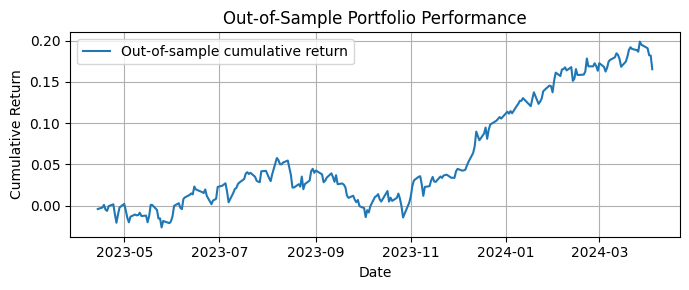

Actual return: 16.53%
Volatility during test: 10.44%


In [5]:
eva.test_portfolio_weights(best, train_data, test_data);

The following shows that all constraints are satisfied:

- All genes sum up to 1 for each chromosome, and in particular in the best solution.
- All genes in the population are below the maximum weight allowed.
- There are no negative genes.

In [6]:
print('sum of genes in best solution: ', best.sum())
print('sum of all genes in population: ', test.population[:,:-1].sum(),
                                                  f'(pop size={test.pop_size})')
print(f"Max gene weight violations in best portfolio: {(test.best_chrom > test.max_w).sum()}")
print(f"Max gene weight violations in population: {(test.population[:, :-1] > test.max_w).sum()}")
print(f"no negative weights in the population:", np.all(test.population>=0))

sum of genes in best solution:  1.0
sum of all genes in population:  100.0 (pop size=100)
Max gene weight violations in best portfolio: 0
Max gene weight violations in population: 0
no negative weights in the population: True


Although from the plot above it looks like the risk of the porfolio violates the hardcoded condition that any portfolio's risk cannot surpass max_risk, which we set to 16%, we have to remember that, during training, the algorithm divides the training set into training and validation, and computes the risk only on the smaller training set. The result of this is shown below, where we can confirm that it is, in fact, below max_risk. The 17.169% risk displayed above comes about when considering the full training set (training + validation) for computing the covariance matrix.

In [7]:
test.volatility(test.best_chrom)

0.15857585311335393

The plot below shows that the population is quickly converging, which reinforces our election to use a uniform parent selection, limiting the selection pressure that could otherwise lead to premature convergence. Also, it can be appreciated that the mutation operator keeps introducing diversity in the population even in later stages of the evolution, which drives further improvements even if diversity is already low, as can be seen by the upwards trend of the fitness evolution plot.

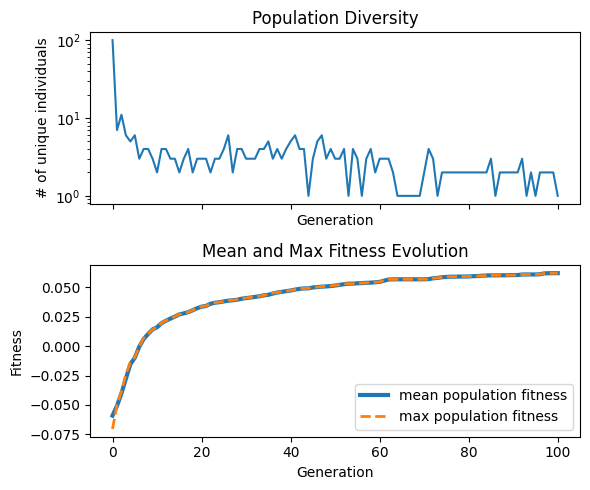

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(6, 5), sharex=True)
test.plot_diversity(ax=axs[0])
test.plot_fitness(ax=axs[1])
plt.tight_layout()
plt.savefig('evolution.jpg')

### Performance

As for performance metrics, we can confirm this naive application is resulting in above average returns ($14.26$%) with risk comparable to those of the benchmark portfolios ($\sim 17$%).

#### MBF (mean best fitness)

In [9]:
best_returns, risks = eva.MBF(train_data, test_data, runs=100, max_risk=max_training_risk, generations=100)

Mean Return at the end of testing period: 14.46%
Mean Risk: 17.1%


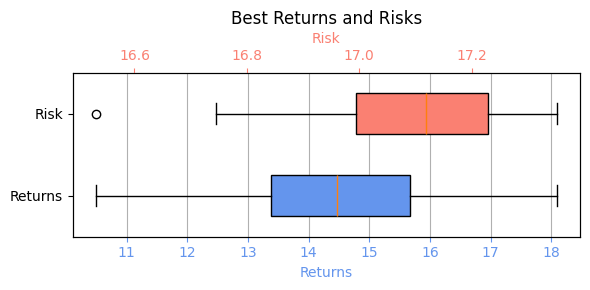

In [10]:
fig, ax1 = plt.subplots(figsize=(6, 3))

# Boxplot for best_returns on ax1
box1 = ax1.boxplot(100 * best_returns, vert=False, positions=[1], widths=0.5, patch_artist=True, boxprops=dict(facecolor='cornflowerblue'))
ax1.set_yticks([1])
ax1.set_yticklabels([''])
ax1.set_xlabel('Returns', color='cornflowerblue')
ax1.tick_params(axis='x', colors='cornflowerblue')
ax1.grid(axis='x')

# Create a twin x-axis for risks
ax2 = ax1.twiny()
box2 = ax2.boxplot(100 * risks, vert=False, positions=[2], widths=0.5, patch_artist=True, boxprops=dict(facecolor='salmon'))
ax2.set_yticks([2])
ax2.set_yticklabels([''])
ax2.set_xlabel('Risk', color='salmon')
ax2.tick_params(axis='x', colors='salmon')

# Set y-ticks and labels for both
ax1.set_yticks([1, 2])
ax1.set_yticklabels(['Returns', 'Risk'])

plt.title('Best Returns and Risks')
plt.tight_layout()
plt.show()

#### AES (Average fitness Evaluations to Solution) + SR (Success Rate)

92% of runs outperformed the benchmark, with an average of 5252 fitness evaluations to success, which ammounts to a few seconds due to the vectorized operations used throughought the training process.

AES: nan
SR: 0.00


e:\documents\ming\intro to evolutionary computation\proyecto final\EA_funcs\metrics.py:104: RuntimeWarning: Mean of empty slice
  print(f'AES: {np.nanmean(evaluations):.2f}')


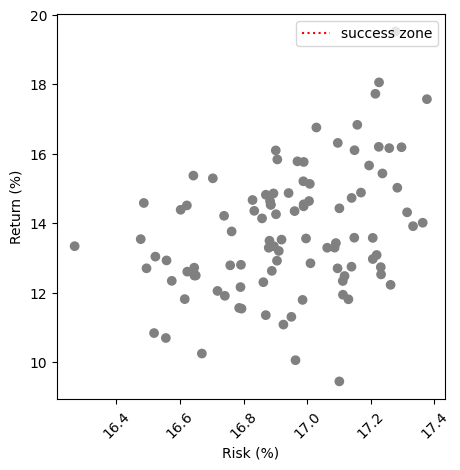

In [11]:
evals, returns, risks = eva.AES_SR(train_data, test_data,
                                   solution=(benchmark_return, benchmark_risk), 
                                   runs=100, plot=True, max_risk=max_training_risk) # Change to 200

# Parameter Selection

Next we perform a series of experiments to try and tune in the values for the main algorithm parameters. 

## Diversification

For this purpose we will start with exploring the effect of allowing for a larger vs. a smaller diversification, which is controlled by the parameter `w_max`: the maximum weight per asset, starting with $1/\text{\# of assets}$, which should return something close the equal weights porfolio, and up to 0.2, or 20% of the total investment, which means the portfolio could include only 5 assets.

In [12]:
# Define the range of max_w values to test
w_start = 1/(0.5 * test_data.shape[1])
ws = np.linspace(w_start, 0.2, 200)

returns = []
risks = []

# Loop over each max_w value
for w in ws:
    # Initialize and run the EA on training data
    ea = eva.EA(train_data, max_w=w, max_risk=max_training_risk)
    ea.run(100)
    
    # Compute out-of-sample return (realized return on test set)
    best = ea.best_chrom
    actual_return = 100 * ea.test_returns(test_data, best)[0]
    
    # Compute in-sample risk using training covariance matrix
    model_risk = 100 * np.sqrt(252 * best @ train_cov_matrix @ best)

    # Store both
    returns.append(actual_return)
    risks.append(model_risk)

We can clearly see that allowing for higher weights per asset resulted in riskier portfolios, which in general had about average returns when put to the test against future, unseen, data, with strong outliers towards the bottom (lower returns). 

In contrast, portfolios with very small allowed maximum weight per asset, and therefore high diversification, had a small training risks with below average benchmark returns by only a little bit. 

Finally, portfolios that were allowed weights a bit higher, but not to high to allow for small porfolios, achieved the best balance between risk and return.

Considering all of this we can confirms the maxim that diversification is usually the way to go, but we shouldn't overdo it. With this in mind, going forward we'll be using a w_max of 0.08.

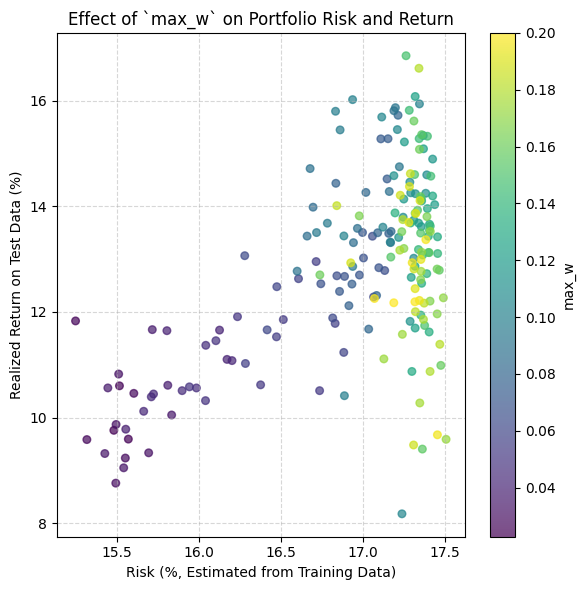

In [13]:
# Plot risk-return points, colored by max_w
fig, ax = plt.subplots(figsize=(6, 6))
scatter = ax.scatter(risks, returns, c=ws, cmap='viridis', s=30, alpha=0.7)
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('max_w')

ax.set_title(r'Effect of `max_w` on Portfolio Risk and Return')
ax.set_xlabel('Risk (%, Estimated from Training Data)')
ax.set_ylabel('Realized Return on Test Data (%)')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("max_w__effect.jpg")


## risk vs. returns prioritization

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
deltas = np.linspace(0, 1, 11)
for delta in deltas:
    ea = eva.EA(train_data, delta=delta, max_w=0.07, max_risk=benchmark_risk)
    returns = []
    risks = []
    for i in range(100):
        ea.run(1)
        best = ea.best_chrom
        returns.append(100 * ea.test_returns(test_data, best)[0])
        risks.append(100 * np.sqrt(252 * best @ train_cov_matrix @ best))
    ax[0].plot(returns)
    ax[1].plot(risks, label=round(delta, 0))
    
plt.legend(bbox_to_anchor=(1, 1.02), title=r'$\delta$')
ax[0].set_ylabel('Test Realized Return')
ax[1].set_ylabel('Training Risk')
ax[0].set_xlabel('Generation')
ax[1].set_xlabel('Generation')
ax[0].set_title('Evolution of \nTest Realized Return')
ax[1].set_title('Evolution of risk')
plt.tight_layout()
plt.savefig('delta_effect_evolution.jpg')

#### MBF for different $\delta$.

In [15]:
deltas = np.linspace(0, 1, 10)
mbfs = np.empty([len(deltas), 2])
for i, delta in enumerate(deltas):
    returns, risks = eva.MBF(train_data, test_data, runs=50, verbose=False, delta=delta, 
                  max_w=0.07, max_risk=benchmark_risk)
    mbfs[i] = (returns.mean(), risks.mean())

<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Juan\AppData\Local\Temp\ipykernel_4356\3345760623.py:15: SyntaxWarning: invalid escape sequence '\d'
  ax1.set_xlabel("$\delta$\nSmaller $\delta$: prioritizes large return\nLarger $\delta$: prioritizes small risk")


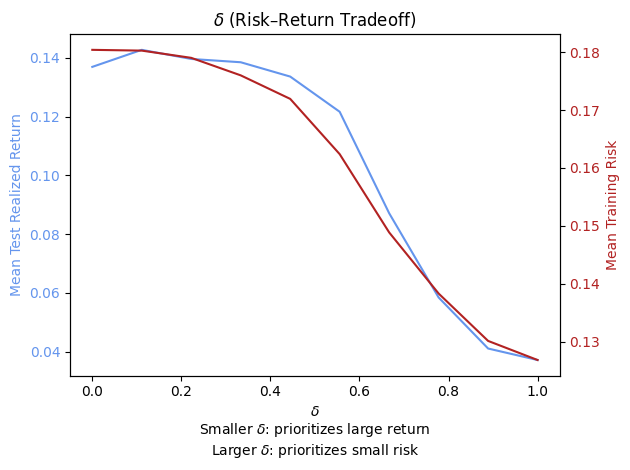

In [16]:
fig, ax1 = plt.subplots()

# Primary y-axis for returns
ax1.plot(deltas, mbfs[:, 0], color='cornflowerblue')
ax1.set_ylabel('Mean Test Realized Return', color='cornflowerblue')
ax1.tick_params(axis='y', labelcolor='cornflowerblue')

# Secondary y-axis for risks
ax2 = ax1.twinx()
ax2.plot(deltas, mbfs[:, 1], color='firebrick')
ax2.set_ylabel('Mean Training Risk', color='firebrick')
ax2.tick_params(axis='y', labelcolor='firebrick')

# Shared x-axis
ax1.set_xlabel("$\delta$\nSmaller $\delta$: prioritizes large return\nLarger $\delta$: prioritizes small risk")

# Title and layout
plt.title(r'$\delta$ (Risk–Return Tradeoff)')
fig.tight_layout()
plt.savefig('risk–return_tradeoff.jpg')

## Mutation Rate

In [ ]:
pm = np.linspace(0, 1, 11)
mbfs = np.empty([len(deltas), 2])
for i, p in enumerate(pm):
    returns, risks = eva.MBF(train_data, test_data, runs=30, verbose=False, p_m=p, 
                  max_w=0.07, max_risk=benchmark_risk)
    mbfs[i] = (returns.mean(), risks.mean())

TypeError: EA.__init__() got an unexpected keyword argument 'pm'

In [ ]:
fig, ax1 = plt.subplots()

# Primary y-axis for returns
ax1.plot(pm, returns, color='cornflowerblue')
ax1.set_ylabel('Test Realized Return', color='cornflowerblue')
ax1.tick_params(axis='y', labelcolor='cornflowerblue')

# Secondary y-axis for risks
ax2 = ax1.twinx()
ax2.plot(pm, risks, color='firebrick')
ax2.set_ylabel('Training Risk', color='firebrick')
ax2.tick_params(axis='y', labelcolor='firebrick')

# Shared x-axis
ax1.set_xlabel(r"$\rho$ (mutation rate)")

# Title and layout
plt.title(r'Effect of Mutation Rate ($\rho$)')
fig.tight_layout()
plt.savefig('mutation_rate_effect.jpg')

## Population size & number of offspring

In [ ]:
returns = []
risks = []
ps = [10, 25, 50, 100, 250, 500, 1000]
for p in ps:
    ea = eva.EA(train_data, pop_size=p, lambda_=6*p, p_m=0.05, max_w=0.08, max_risk=benchmark_risk,
            testing=False)
    ea.run(int(100/np.log10(p)))

    best = ea.best_chrom
    returns.append(ea.test_returns(test_data, best)[0])
    risks.append(100 * np.sqrt(252 * best @ train_cov_matrix @ best))

plt.plot(ps, returns)
plt.title(r'Best Returns vs. $\mu$')
plt.xscale('log')
plt.xlabel(r'$\mu$')
plt.ylabel('Test Realized Return (%)')
plt.tight_layout()
plt.savefig('returns_vs_pop_size.jpg')

In [ ]:
returns, risks = eva.MBF(train_data, test_data, p_m=0.05, max_w=0.08, pop_size=1000,
                           delta=0.51, lambda_=6000, runs=10, generations=50)

In [ ]:
returns, risks = eva.AES_SR(train_data, solution=0.208, max_risk=0.181,
                               max_gens=50, p_m=0.05, max_w=0.08, delta=0.51,
                               runs=30)

In [ ]:
plt.scatter(risks2, returns2)
plt.xlabel('Riesgo')
plt.ylabel('Retorno Esperado')
plt.title('Resultados de la Prueba de Desempeño')
plt.tight_layout()
plt.savefig('resultados.jpg')

In [ ]:
test = eva.EA(train_data, p_m=0.05, max_w=0.08, pop_size=2000, lambda_=12000, delta=0.51)
test.fitness(test.best_chrom)

# Robustness tests

### With respect to search space (*i.e.* different asset sets).

In [ ]:
returns, risks = eva.asset_robustness(data = eva.all_data, sample_size=100, generations=50, runs=10, max_w=0.07, p_m=0.05)

In [ ]:
sns.scatterplot(x=risks, y=returns, legend='brief', alpha=0.7, s=80)

plt.title('Robustness Test for Different Asset Groups')
plt.xlabel('Risk (%, Estimated from Training Data)')
plt.ylabel('Test Return (%)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Test #')

min_risk, max_risk = risks.min(), risks.max()
min_return, max_return = returns.min(), returns.max()

# Add small margins so lines and points aren't right on the edges
x_margin = 0.05 * (max_risk - min_risk)
y_margin = 0.05 * (max_return - min_return)

# Adaptively set axis limits
x_min = min_risk - x_margin
x_max = max_risk + x_margin
y_min = min_return - y_margin
y_max = max_return + y_margin

plt.hlines(100*benchmark_return, x_min, 100*benchmark_risk, color="red", linestyle=":", label="success zone")
plt.vlines(100*benchmark_risk, 100*benchmark_return, y_max, color="red", linestyle=":")

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.savefig('asset_robustness.jpg', bbox_inches='tight')

### With respect to different timeframes

In [ ]:
results = eva.time_robustness(data=eva.all_data, periods=5, generations=50, max_w=0.07, p_m=0.05)

returns = results['EA_returns']
risks = results['EA_risks']

In [ ]:
sns.scatterplot(x=risks, y=returns, legend='brief', alpha=0.7, s=80)

plt.title('Robustness Test for Different Time Periods')
plt.xlabel('Generación')
plt.tight_layout()
plt.savefig('time_robustness.jpg')
